In [1]:
from data_treat.get_ready_data import get_data
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc # метрики качества
from sklearn.metrics import confusion_matrix, accuracy_score # метрики качества
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from data_treat.data_normalizer import CustomNormalizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
import xgboost as xgb
from xgboost import plot_tree

In [2]:
COLUMNS = ["distance_from_home","distance_from_last_transaction","ratio_to_median_purchase_price",
           "repeat_retailer","used_chip","used_pin_number","online_order", "fraud"]

In [3]:
data = get_data()


1.0    87403
0.0    87403
Name: fraud, dtype: int64

In [4]:
def feture_importants(importantance):
    res = '\n feature_importance \n'
    for ind, imp in enumerate(importantance):
        res += f"{COLUMNS[ind]} :  {imp}\n"

    return res

In [5]:
target_variable_name = 'fraud'
labels = data[target_variable_name]
data = data.drop(target_variable_name, axis=1)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

In [7]:
def model_func(x_train,x_test):
    def gridSearch(X,y):

        param_dict = {
        "n_estimators" : np.arange(20,24,1)
        }
        model = xgb.XGBClassifier(random_state=0)
        gv = GridSearchCV(model,param_grid=param_dict)
        gv.fit(X,y)
        return gv.best_score_,gv.best_params_

    params = gridSearch(x_train, y_train)
    print(params)

    model = xgb.XGBClassifier(n_estimators = params[1]['n_estimators'],random_state=0)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)

    print("Accuracy : ",accuracy_score(y_test,predictions)*100)
    print(confusion_matrix(y_test, predictions))

    test_probabilities = model.predict_proba(x_test)
    test_probabilities = test_probabilities[:, 1]
    false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, test_probabilities)

    plt.figure(figsize=(7, 7))

    # рисуем кривую
    plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

    # кривая, соответствующая случайному угадыванию
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.fill_between(false_positive_rates, true_positive_rates, step="mid", alpha=0.4, label='площадь под кривой (ROC-AUC)')
    plt.legend()
    plt.show()

    roc_auc_value = roc_auc_score(y_test, test_probabilities)

    print("ROC-AUC на тестовой выборке:", roc_auc_value)

    print(feture_importants(model.feature_importances_ ))

Для сырых данных

In [9]:
import graphviz
model = xgb.XGBClassifier(n_estimators = 20,random_state=0)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
xgb.to_graphviz(model, num_trees=19, rankdir='LR')

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

(0.9881403688524589, {'n_estimators': 20})
Accuracy :  98.70852546545089
[[28420   404]
 [  341 28521]]


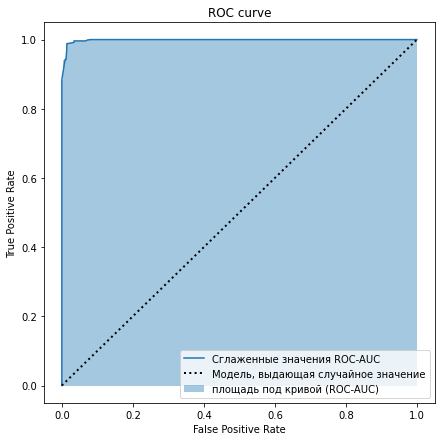

ROC-AUC на тестовой выборке: 0.9986122549333836

 feature_importance 
distance_from_home :  0.1645907610654831
distance_from_last_transaction :  0.11484155058860779
ratio_to_median_purchase_price :  0.6181688904762268
repeat_retailer :  0.0
used_chip :  0.04549725353717804
used_pin_number :  0.015276950784027576
online_order :  0.04162457212805748



In [19]:
model_func(x_train, x_test)

Для нормализованных данных

(0.9881403688524589, {'n_estimators': 20})
Accuracy :  90.35814582394342
[[24188  4636]
 [  926 27936]]


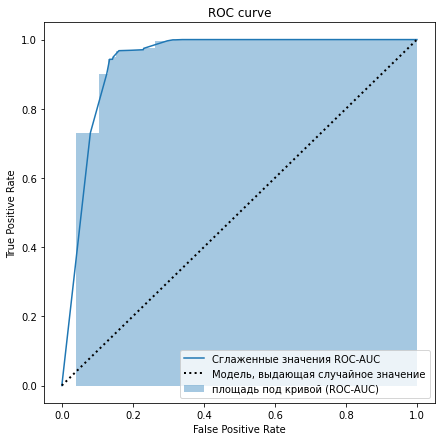

ROC-AUC на тестовой выборке: 0.9354619110140299

 feature_importance 
distance_from_home :  0.1645907610654831
distance_from_last_transaction :  0.11484155058860779
ratio_to_median_purchase_price :  0.6181688904762268
repeat_retailer :  0.0
used_chip :  0.04549725353717804
used_pin_number :  0.015276950784027576
online_order :  0.04162457212805748



In [22]:
model_func(CustomNormalizer.normalize(x_train),CustomNormalizer.normalize(x_test))

(0.9881403688524589, {'n_estimators': 20})
Accuracy :  98.16419928578858
[[28068   756]
 [  303 28559]]


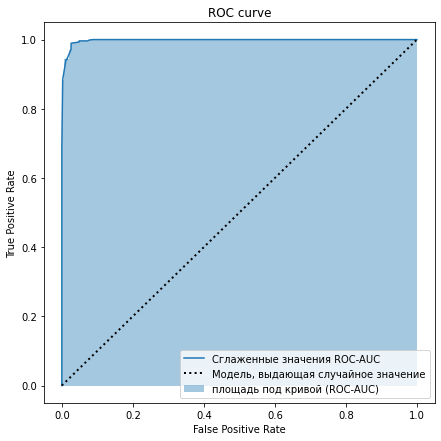

ROC-AUC на тестовой выборке: 0.9976999928627606

 feature_importance 
distance_from_home :  0.1645907610654831
distance_from_last_transaction :  0.11484155058860779
ratio_to_median_purchase_price :  0.6181688904762268
repeat_retailer :  0.0
used_chip :  0.04549725353717804
used_pin_number :  0.015276950784027576
online_order :  0.04162457212805748



In [23]:
model_func(CustomNormalizer.standardize(x_train),CustomNormalizer.standardize(x_test))